# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

Откроем таблицу с данными:

In [3]:
# импортируем все необходимые библиотеки
import pandas as pd 
import matplotlib.pyplot as plt
# применим к таблице параметр sep
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t') 

In [4]:
print(data) # выводим таблицу на экран

       total_images  last_price  total_area first_day_exposition  rooms  \
0                20  13000000.0      108.00  2019-03-07T00:00:00      3   
1                 7   3350000.0       40.40  2018-12-04T00:00:00      1   
2                10   5196000.0       56.00  2015-08-20T00:00:00      2   
3                 0  64900000.0      159.00  2015-07-24T00:00:00      3   
4                 2  10000000.0      100.00  2018-06-19T00:00:00      2   
...             ...         ...         ...                  ...    ...   
23694             9   9700000.0      133.81  2017-03-21T00:00:00      3   
23695            14   3100000.0       59.00  2018-01-15T00:00:00      3   
23696            18   2500000.0       56.70  2018-02-11T00:00:00      2   
23697            13  11475000.0       76.75  2017-03-28T00:00:00      2   
23698             4   1350000.0       32.30  2017-07-21T00:00:00      1   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0                2.70 

Выведем общую информацию о полученном датафрейме:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Датафрейм имеет: 
* 3 таблицы с целыми числами:  total_images, rooms, floor.
* 14 таблиц с дробными числами: last_price, total_area и тд.
* 3 таблицы с типом данных объекты: first_day_exposition, is_apartment, locality_name.
* 2 таблицы с булевым типом данных: studio, open plan.


Построим общую гистограмму по всем выбранным столбцам:

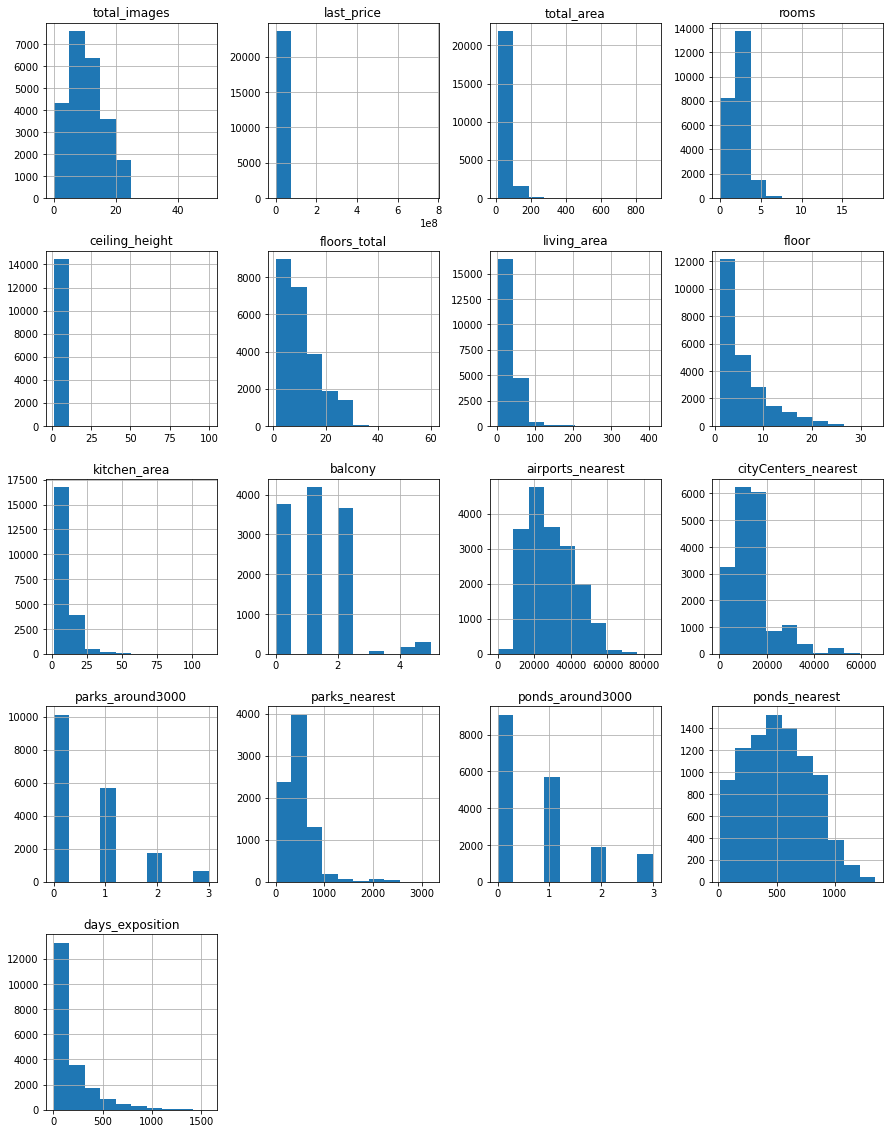

In [6]:
data.hist(figsize=(15, 20));

### Предобработка данных

#### Изучение пропущенных значений в столбцах

Теперь найдем количество пропущенных значений в каждом столбце при помощи метода isna() и sum()

In [7]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Большая часть таблиц в датафрейме имеют разного характера пропущенные значения. Необходимо проанализировать таблицы и выявить причины, а также заменить там, где необходимо, пропущенные значения.

In [8]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

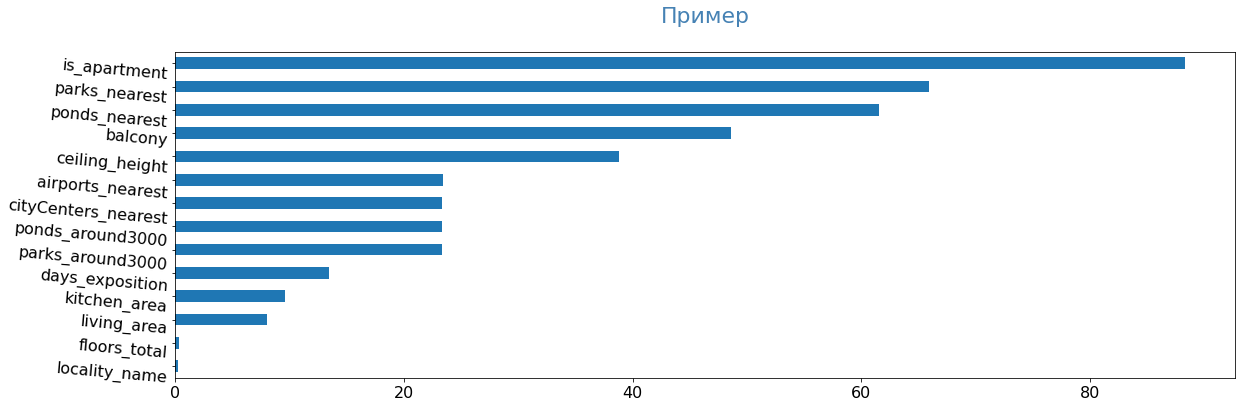

In [9]:
pass_value_barh(data)

* ceiling_height (Высота потолков). Пропуски значений связанны с человеским фактором либо отсутсвием проводимых измерений. Также наблюдаются выбросы значений от 10 до 100 м. Заполним пропуски мединным значением.
* floors_total (количество этажей в доме). Пропуски значений могут быть связанны с человеческим фактором, либо переформатированием данных. Заменить пустые значения в данном случае не получится, поэтому от них придется избавиться. 
* living_area (жилая площадь в квадратных метрах (м²)), наличие пропусков могут быть связаны с отсутствием измерений, эти значения можно заменить медианным значением.
* is_apartment (апартаменты) являются булевым типом, отвечающая истинностью или ложностью утверждения. В этой таблице помимо False и True наблюдаются пропущенные значения. Заменим Nan на False.
* kitchen_area (площадь кухни в квадратных метрах (м²)) пропуски в данных могут быть связаны с отсутствием измерений в следствии человеческого фактора либо переформатированием данных. Заполним медианным значением.
* balcony (число балконов). Исходя из таблицы можно заметить, там, где отсутствуют балконы стоят значения Nan и 0. Заменим пустые значения нулями.
* locality_name (название населённого пункта). Пропуски в этой таблицы могут быть связанны с отсутствием данных о местоположении дома, либо человеческим фактором. Здесь не получится заменить пропущенные значения, поэтому от них придется избавиться. 
* airports_nearest (расстояние до ближайшего аэропорта в метрах (м)) Не получится заменить данные, так как как отсутствуют данные.
* cityCenters_nearest (расстояние до центра города (м)). Не получится заменить пропущенные значения так мы не знаем расположения дома.
* parks_around3000 (число парков в радиусе 3 км). Пропущенные могут означать, что в радиусе 3 км парков нет, поэтому исходя из таблицы заменим пропущенные значения Nan на 0.    
* parks_nearest (расстояние до ближайшего парка (м)). В данном случае не получится заменить значения, так мы не знаем точного расположения города и близлежащего парка.
* ponds_around3000 (число водоёмов в радиусе 3 км) здесь аналогичная ситуация, как и с парками в радиусе 3 км. Заменим пустые значения на 0.
* ponds_nearest (расстояние до ближайшего водоёма (м)). Не получится заменить пропущенные значения, так как мы не знаем точного расположения дома и центра города.
* days_exposition (сколько дней было размещено объявление (от публикации до снятия)). Пропуски в этой таблице могут быть связанны с человеческим фактором или переформатированием данных. Сделать замены не получится 


Выведем те уникальные значения, для которых можно будет осуществить замену пропусков и проверим гипотезы.

In [10]:
print(data['balcony'].unique())
print()

print(data['is_apartment'].unique())
print()

print(data['parks_around3000'].unique())
print()

print(data['ponds_around3000'].unique())
print()

[nan  2.  0.  1.  5.  4.  3.]

[nan False True]

[ 1.  0.  2. nan  3.]

[ 2.  0.  3.  1. nan]



1) balcony (число балконов), пустые значения заменим на ноль.

2) is_apartment (апартаменты), заменим Nan на False.

3) parks_around3000 (число парков в радиусе 3 км) и ponds_around3000 (число водоёмов в радиусе 3 км), также произведем замены Nan на ноль.



Теперь заменем пустые значения в таблице медианным значением:

In [77]:
# Заполнение пустот для высоты потолков
data['ceiling_height'] = (
    data.groupby(['locality_name', 'floors_total'])['ceiling_height']
    .apply(lambda x: x.fillna(x.median()))
) 
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)

# Найдем среднее соотношение жилой площади к общей площади и сохраним его в ratio_kitchen
ratio_living = data['living_area'].mean() / data['total_area'].mean()
# Заполненяем пустые значения жилой площади по общей площади умноженное на среднее соотношение ratio_kitchen
data['living_area'].fillna(ratio_living * data['total_area'].median(), inplace=True) 

# Найдем среднее соотношение площади кухни к общей площади и сохраним его в ratio_kitchen
ratio_kitchen = data['kitchen_area'].mean() / data['total_area'].mean()
# Заполненяем пустые значения площади кухни по общей площади умноженное на среднее соотношение ratio_kitchen
data['kitchen_area'].fillna(ratio_kitchen * data['total_area'].median(), inplace=True)


Удалим пустые значение в таблицах по этажам и локации: 


In [12]:
data.dropna(subset=['locality_name'], inplace=True)
data.dropna(subset=['floors_total'], inplace=True) 

Произведем замену пропущеных значений в таблицах balcony, parks_around3000, ponds_around3000:

In [13]:
passes = ['balcony', 'parks_around3000', 'ponds_around3000'] # Создадим список, который переберет его элементы циклом for 
# и выполнит замену пропущенных значений.
for column in passes:
    data[column] = data[column].fillna(0)

Также произведем замену пропущеных значений в таблице is_apartment:

In [14]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Выведем таблицы, в которых были произведены замены и посмотрим на количество пропусков:

In [15]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
dtype: int64


**Выводы**: Основными причинами пропусков могут быть:
1) Человеческий фактор.

2) Переформатирования данных из чего меняются либо перезаписываются значения.

3) Отсутвие данных по объекту


#### Рассмотрение типов данных

Рассмотрим еще раз тип данных в каждом столбце

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

In [17]:
# Приводим в целочисленный формат таблицы:
for index in data[['floors_total', 'floor', 'balcony', 'last_price', 'parks_around3000', 'ponds_around3000']]:
     data[index] = data[index].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  int64  
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  int64  
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  int64  
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Необходимо поменять формат object на дату в таблице first_day_exposition, для этого необходимо преобразовать все значения методом to_datetime 

In [18]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') 
#приводим все числа к формату даты 
print(data['first_day_exposition'])

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23565, dtype: datetime64[ns]


**Выводы**: 
1) Таблица first_day_exposition поменялся формат на datetime64. Это необходимо, так как данный столбец показывает дату, месяц и число.

2) К целочисленным значениям приведены таблицы с количественными данными, так как они показывают количество того или иного объекта и поэтому не могут иметь дробную часть. Также были переведены таблицы указывающие стоимость дома в целочисленный тип.


#### Изучение уникальных значений в столбце с названиями и устранение неявных дубликатов

Проверим уникальные значения в столбце с названиями и устраним неявные дубликаты в таблице:

In [19]:
data['locality_name'].sort_values().unique() # Отсортируем все уникальные значения в таблице 

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Узнаем количество уникальных значений:

In [20]:
data['locality_name'].nunique()

364

Уберем лишние названия и привидем таблицу в более наглядное состояние. Для этого изменим:
1) поселок на посёлок.

2) городской посёлок на посёлок городского типа

3) заменим все остальные значения на посёлок, чтобы убрать повторяющиеся значения 

In [21]:
data['locality_name'] = data['locality_name'].replace({'поселок':'посёлок', 
                                                       'деревня': 'посёлок', 
                                                       'городской посёлок': 'посёлок городского типа', 
                                                       'село': 'посёлок', 
                                                       'садовое товарищество': 'посёлок', 
                                                       'посёлок при железнодорожной станции': 'посёлок', 
                                                       'садоводческое некоммерческое товарищество': 'посёлок',
                                                       'посёлок станции': 'посёлок',
                                                       'коттеджный посёлок': 'посёлок'
                                                       }, regex=True) # Производим замены по выбранным категориям 



Выведем таблицу с уникальными значениями:

In [22]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской посёлок Большая Ижора', 'городской посёлок Янино-1',
       'коттеджный посёлок Кивеннапа Север', 'коттеджный посёлок Счастье',
       'посёлок Агалатово', 'посёлок Александровская',
       'посёлок Алексеевка', 'посёлок Аннино', 'посёлок Аро',
       'посёлок Барышево', 'посёлок Батово', 'посёлок Бегуницы',
       'посёлок Белогорка', 'посёлок Белоостров', 'посёлок Большая

Выведем еще раз количество уникальных значений: 

In [23]:
data['locality_name'].nunique()

318

Количевство уникальных значений уменьшилось с 364 до 318

#### устранение редких и выбивающихся значений

Найдем редкие и выбивающиеся значения по потолкам:

In [24]:
data['ceiling_height'].unique()

array([  2.7  ,   2.65 ,   2.6  ,   3.03 ,   2.625,   2.75 ,   2.5  ,
         2.67 ,   2.55 ,   2.56 ,   3.05 ,   3.   ,   2.9  ,   2.8  ,
         2.76 ,   3.2  ,   2.645,   2.61 ,   2.54 ,   3.15 ,   3.25 ,
         3.45 ,   2.77 ,   2.85 ,   2.64 ,   2.57 ,   4.15 ,   3.5  ,
         3.3  ,   2.71 ,   4.   ,   2.47 ,   2.73 ,   2.84 ,   3.1  ,
         2.675,   2.34 ,   3.4  ,   2.52 ,   3.06 ,   2.72 ,   2.51 ,
         2.78 ,  13.85 ,   2.725,  25.   ,   2.58 ,   3.7  ,  14.85 ,
         5.2  ,   2.575,   2.525,   2.745,   2.87 ,   2.66 ,   2.775,
         2.59 ,   2.   ,   2.45 ,   3.6  ,   5.   ,   2.92 ,   2.505,
         3.11 ,   3.13 ,   2.735,   3.8  ,   3.55 ,   3.16 ,   3.62 ,
         3.12 ,   2.53 ,   2.565,   2.74 ,   2.96 ,   2.46 ,   5.3  ,
         2.79 ,   2.95 ,   4.06 ,   2.94 ,   3.82 ,   3.54 ,   3.53 ,
         2.83 ,   3.325,   4.7  ,   2.4  ,   3.38 ,   3.01 ,   5.6  ,
         2.65 ,   3.65 ,   3.9  ,   3.18 ,   3.35 ,   2.3  ,   3.57 ,
         2.48 ,   2.

Выведем аномольные значения:

In [25]:
data.loc[data['ceiling_height'] > 20]['ceiling_height'].unique()


array([ 25. ,  32. ,  27. ,  24. ,  26. ,  22.6,  27.5, 100. ])

Обработаем аномальные значения и сохраним их в таблицу:

In [26]:
data['ceiling_height'] = data['ceiling_height'].replace({25.: 2.5, 
                                                      32.: 3.2,
                                                      27.: 2.7,
                                                      26.: 2.6,
                                                      22.6: 2.26,
                                                      24.: 2.4,
                                                      27.5: 2.75},regex=True) # Производим обработку аномальных чисел

Еще раз выведем значения больше 20

In [27]:
data.loc[data['ceiling_height'] > 20]['ceiling_height'].unique()

array([100.])

Избавимся от лишних значений, введем ограничение по потолкам:

In [28]:
data = data.loc[(data['ceiling_height'] > 2) & (data['ceiling_height'] < 4)]

In [29]:
data['ceiling_height'].unique()

array([2.7  , 2.65 , 2.6  , 3.03 , 2.625, 2.75 , 2.5  , 2.67 , 2.55 ,
       2.56 , 3.05 , 3.   , 2.9  , 2.8  , 2.76 , 3.2  , 2.645, 2.61 ,
       2.54 , 3.15 , 3.25 , 3.45 , 2.77 , 2.85 , 2.64 , 2.57 , 3.5  ,
       3.3  , 2.71 , 2.47 , 2.73 , 2.84 , 3.1  , 2.675, 2.34 , 3.4  ,
       2.52 , 3.06 , 2.72 , 2.51 , 2.78 , 2.725, 2.58 , 3.7  , 2.575,
       2.525, 2.745, 2.87 , 2.66 , 2.775, 2.59 , 2.45 , 3.6  , 2.92 ,
       2.505, 3.11 , 3.13 , 2.735, 3.8  , 3.55 , 3.16 , 3.62 , 3.12 ,
       2.53 , 2.565, 2.74 , 2.96 , 2.46 , 2.79 , 2.95 , 2.94 , 3.82 ,
       3.54 , 3.53 , 2.83 , 3.325, 2.4  , 3.38 , 3.01 , 2.65 , 3.65 ,
       3.9  , 3.18 , 3.35 , 2.3  , 3.57 , 2.48 , 2.62 , 2.82 , 3.98 ,
       2.63 , 3.83 , 2.715, 3.52 , 3.95 , 3.75 , 2.88 , 3.67 , 3.87 ,
       3.66 , 3.85 , 3.86 , 3.24 , 3.36 , 3.08 , 3.68 , 3.07 , 3.37 ,
       3.09 , 3.26 , 3.34 , 2.775, 2.81 , 3.44 , 2.97 , 3.14 , 2.68 ,
       2.6  , 3.22 , 3.27 , 2.93 , 3.46 , 2.785, 3.47 , 3.33 , 3.63 ,
       3.32 , 2.98 ,

In [30]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,449.00","23,449.00","23,449.00","20,304.00","23,449.00","23,449.00","23,449.00","23,449.00","23,449.00"
min,0.00,12.00,2.20,1.00,"12,190.00",2.00,1.30,1.00,1.00
max,19.00,900.00,3.98,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00


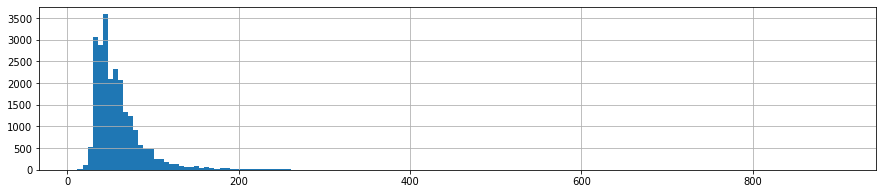

In [31]:
# check
data.total_area.hist(bins = 150, figsize = (15,3));

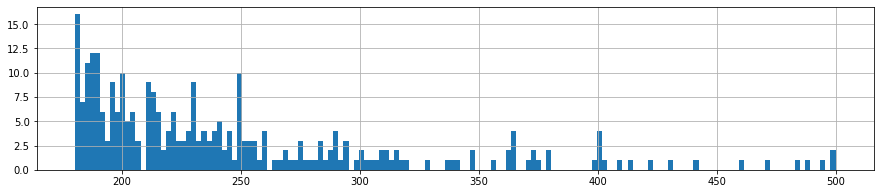

In [32]:
# check
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));


Избавимся от редких выбивающихся значений по количествам комнат:

In [33]:
# Выведем численность квартир с количеством их комнат: 
data.rooms.value_counts().to_frame()

,rooms
1,7981
2,7865
3,5747
4,1163
5,314
0,193
6,99
7,57
8,11
9,8


In [34]:
# Отбросим редкие значения по комнатам
data = data.loc[(data['rooms'] < 8)]

Теперь обработаем редкие выбивающиеся значения по площадям квартир:

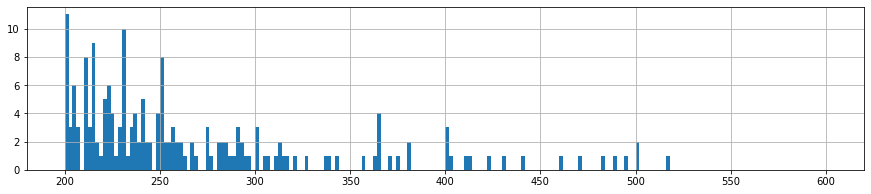

In [35]:
# Построим гистограмму по площадям всех квартир
data.total_area.hist(bins = 200, figsize = (15,3), range= (200,600));

Квартиры имещюие площадь больше 200 метров можно считать редкостями, поэтому отбросим эти значения

In [36]:
# Отбросим редкие значения по общей площади
data = data.loc[(data['total_area'] <= 200)]

Теперь обработаем редкие выбивающиеся значения по ценнам

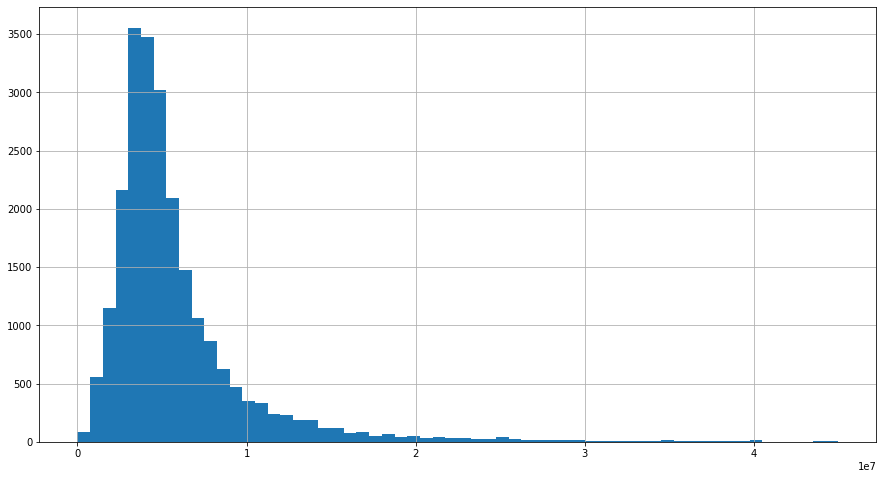

In [37]:
# Построим гистограмму по стоимости квартир и поставим диапазон цен от 0 до 450 тыс.руб.
data.last_price.hist(bins = 60, figsize = (15, 8), range= (0, 45000000));

In [38]:
# Отбросим редкие значения по ценам
data = data.loc[(data['last_price'] > 450000) & (data['last_price'] < 30000000)]

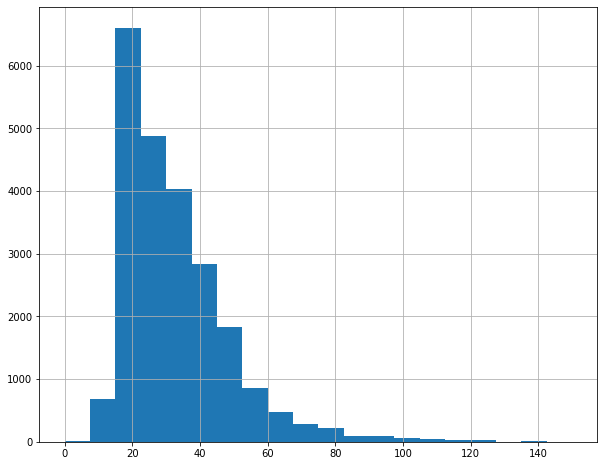

In [39]:
# Построим гистограмму по жилой площади
data.living_area.hist(bins = 20, figsize = (10, 8), range = (0, 150));

In [40]:
# Отбросим редкие значения по жилой площади
data = data.loc[(data['living_area'] < 100)]

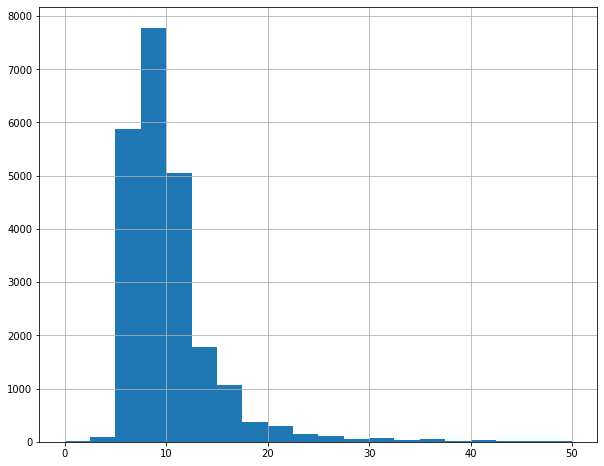

In [41]:
# Построим гистограмму по кухням 
data.kitchen_area.hist(bins = 20, figsize = (10, 8), range = (0, 50));

In [42]:
# Отбросим редкие значения по кухням 
data = data.loc[(data['kitchen_area'] < 30)]

In [43]:
# Выводим последние значения по этажам в доме
data.floors_total.value_counts().to_frame().tail(10)

,floors_total
26,123
1,24
35,24
28,21
36,2
34,1
60,1
52,1
29,1
33,1


In [44]:
# Отбросим редкие значения по этажам в доме
data = data.loc[(data['floors_total'] < 29)]

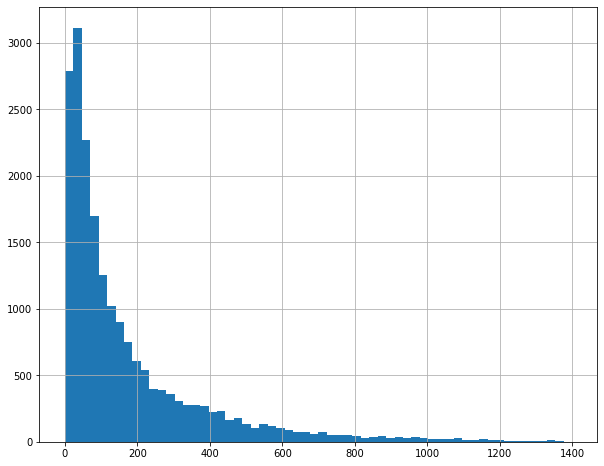

In [45]:
data.days_exposition.hist(bins = 60, figsize = (10, 8), range = (0, 1400));

In [78]:
data = data.loc[(data['days_exposition'] < 1200)]

In [79]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.01,1.00,25.00,2.50,4.00,"1,050,000.00",13.00,5.00,1.00,2.00
0.5,2.00,50.00,2.65,92.00,"4,450,000.00",29.69,9.11,4.00,9.00
0.9,3.00,83.90,3.00,440.00,"8,999,999.00",49.30,14.00,13.00,23.00
0.9976,5.00,156.00,3.70,"1,126.90","25,500,000.00",92.34,27.00,25.00,27.00


**Вывод**: В таблице были выявлены данные с очень большими показателями, вероятно связанные с человескими факторами, а также редкие и выбивающиеся значения.  

In [48]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,618.00","22,618.00","22,618.00","19,686.00","22,618.00","22,618.00","22,618.00","22,618.00","22,618.00"
min,0.00,12.00,2.20,1.00,"470,000.00",2.00,1.30,1.00,1.00
max,7.00,200.00,3.98,"1,580.00","29,999,000.00",99.90,29.90,27.00,28.00


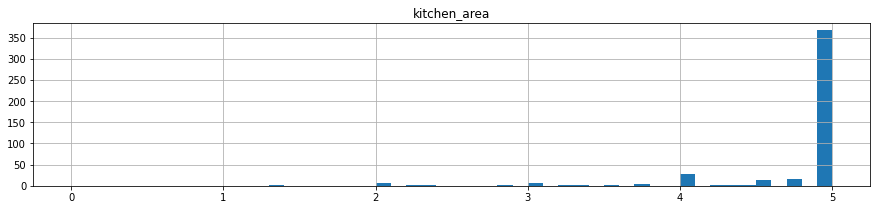

In [49]:
# check
data.hist(column = 'kitchen_area', bins = 50, figsize = (15,3), range = (0,5));

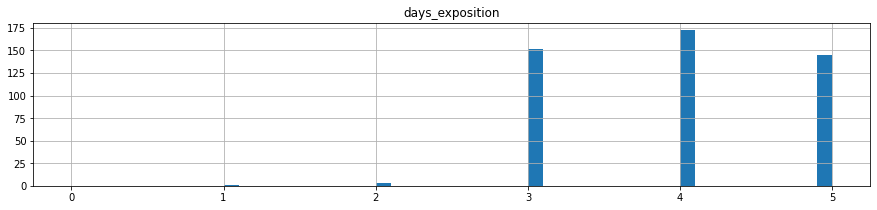

In [50]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

### Посчитайте и добавьте в таблицу новые столбцы

In [51]:
# Посчитаем цену одного квадратного метра и выведем её на экран:
data['price_sq_meters'] = data['last_price'] / data['total_area']
# Переведём значение в целочисленный тип
data['price_sq_meters'] = data['price_sq_meters'].astype(int)

Выведем в отдельные таблицы дни, месяцы и года.

In [52]:
# создание столбца по каждому дню:
data['weekday'] = data['first_day_exposition'].dt.weekday
# создание столбца по каждому месяцу:
data['month'] = data['first_day_exposition'].dt.month
# создание столбца по каждому году:
data['year'] = data['first_day_exposition'].dt.year

Теперь разделим типы этажей по значениям первый, последний и другой с помощью функции def и сохраним и создадим для нее новую таблицу:

In [53]:
def storeys(x):
    try:
        if x['floor'] == 1:
            return 'первый'
        elif x['floor'] == x['floors_total']:
            return 'последний'
        else:
            return 'другой'
    except:
        print('Значение не подходит под указанную категорию')
data['type_floors'] = data.apply(storeys, axis=1)

In [54]:
data['center_in_km'] = (data['cityCenters_nearest'] / 1000)
# заменим пустые значения на 0 и приведём к целочисленному формату
data['center_in_km'] = data['center_in_km'].fillna(0).astype(int) 
display(data) # выведем таблицу data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_meters,weekday,month,year,type_floors,center_in_km
0,20,13000000,108.00,2019-03-07,3,2.700,16,51.000000,8,False,...,482.0,2,755.0,NaN,120370,3,3,2019,другой,16
1,7,3350000,40.40,2018-12-04,1,2.650,11,18.600000,1,False,...,NaN,0,NaN,81.0,82920,1,12,2018,первый,18
2,10,5196000,56.00,2015-08-20,2,2.600,5,34.300000,4,False,...,90.0,2,574.0,558.0,92785,3,8,2015,другой,13
5,10,2890000,30.40,2018-09-10,1,2.625,12,14.400000,5,False,...,NaN,0,NaN,55.0,95065,0,9,2018,другой,0
6,6,3700000,37.30,2017-11-02,1,2.600,26,10.600000,6,False,...,NaN,0,NaN,155.0,99195,3,11,2017,другой,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.700,5,73.300000,3,False,...,796.0,3,381.0,NaN,72490,1,3,2017,другой,4
23695,14,3100000,59.00,2018-01-15,3,2.500,5,38.000000,4,False,...,NaN,0,NaN,45.0,52542,0,1,2018,другой,0
23696,18,2500000,56.70,2018-02-11,2,2.650,3,29.700000,1,False,...,NaN,0,NaN,NaN,44091,6,2,2018,первый,0
23697,13,11475000,76.75,2017-03-28,2,3.000,17,29.690942,12,False,...,173.0,3,196.0,602.0,149511,1,3,2017,другой,10


### Проведите исследовательский анализ данных

#### Изучение параметров объектов

Построим гистограмму для каждого значения таблицы:

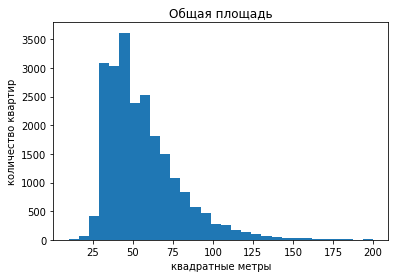


Наибольшие по площади дома:
12055    200.0
15079    199.2
10315    198.0
2709     197.0
12922    197.0
2756     196.0
12835    193.2
21338    190.0
19183    190.0
19208    187.0
Name: total_area, dtype: float64


In [55]:
# Гистограмма общей площади
plt.hist(data['total_area'], bins=30, range=(10,200))
plt.title('Общая площадь')
plt.xlabel('квадратные метры')
plt.ylabel('количество квартир')
plt.show()
print()
print('Наибольшие по площади дома:') 
print(data['total_area'].sort_values(ascending=False).head(10))

Больше всего домов имеют площадь от 30 до 45 кв. метров. Максимальную общую площадь в 900 кв метров имеет дом с номером 19540 

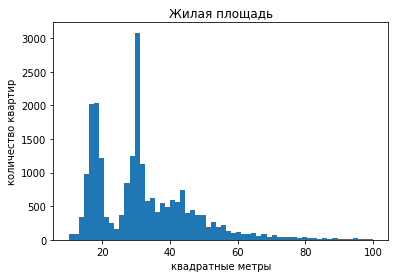

Наибольшие по жилой площади дома:
7377     99.9
4977     99.7
19775    99.6
496      99.5
7721     99.5
7938     99.3
17534    99.1
13082    99.0
18217    99.0
19084    98.9
Name: living_area, dtype: float64


In [56]:
plt.hist(data['living_area'], bins=60, range=(10,100))
plt.title('Жилая площадь')
plt.xlabel('квадратные метры')
plt.ylabel('количество квартир')
plt.show()
print('Наибольшие по жилой площади дома:') 
print(data['living_area'].sort_values(ascending=False).head(10))

Больше всего домов имеют жилую площадь 30 кв. метров. Максимальные значение по жилой площади 409.7  кв. метра имеет дом под номером 19540

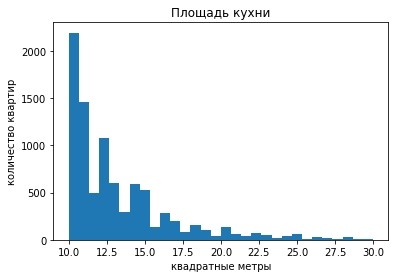


Наибольшие показатели по площади кухни:
14099    29.9
1560     29.9
15813    29.8
12263    29.5
22718    29.4
3741     29.4
19194    29.4
6287     29.4
4081     29.3
20771    29.3
Name: kitchen_area, dtype: float64


In [57]:
plt.hist(data['kitchen_area'], bins=30, range=(10,30))
plt.title('Площадь кухни')
plt.xlabel('квадратные метры')
plt.ylabel('количество квартир')
plt.show()
print()
print('Наибольшие показатели по площади кухни:') 
print(data['kitchen_area'].sort_values(ascending=False).head(10))

Размер кухни в большинстве домов составляет 11 кв. метров. Максимальный показатель равен 112 кв. метрам.

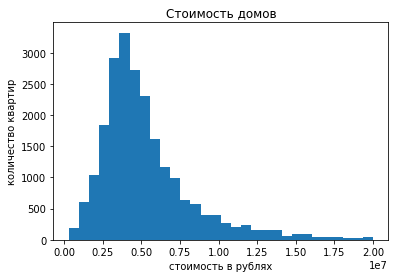


Наибольшие показатели по стоимости домов:
11530    29999000
6922     29999000
17378    29990000
11151    29990000
19773    29900000
20977    29849500
21143    29800000
20775    29800000
13113    29500000
2414     29500000
Name: last_price, dtype: int64


In [58]:
plt.hist(data['last_price'], bins=30, range=(300000,20000000))
plt.title('Стоимость домов')
plt.xlabel('стоимость в рублях')
plt.ylabel('количество квартир')
plt.show()
print()
print('Наибольшие показатели по стоимости домов:') 
print(data['last_price'].sort_values(ascending=False).head(10))

Больше всего домов имеют цену около 3 млн рублей. Наибольшую стоимость имеет дом 12971.

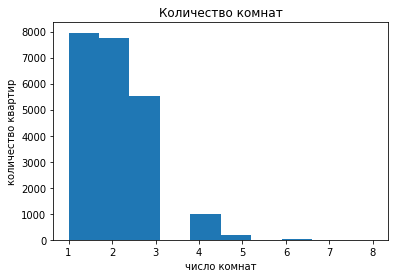


Наибольшие количество комнат:
22264    7
855      7
15196    7
17991    7
23555    7
14603    7
3324     6
201      6
21218    6
11409    6
Name: rooms, dtype: int64


In [59]:
plt.hist(data['rooms'], bins=10, range=(1,8))
plt.title('Количество комнат')
plt.xlabel('число комнат')
plt.ylabel('количество квартир')
plt.show()
print()
print('Наибольшие количество комнат:') 
print(data['rooms'].sort_values(ascending=False).head(10))

Больше всего домов имеют одну или две комнаты. Максимальное количество комнат имеет дом 14498

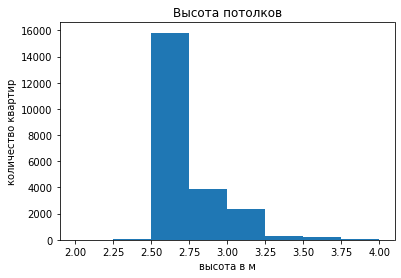


Наибольшая высота потолков:
1977     3.98
2676     3.95
19852    3.95
12199    3.95
4917     3.95
15119    3.95
13982    3.93
8614     3.90
4406     3.90
15531    3.90
Name: ceiling_height, dtype: float64


In [60]:
plt.hist(data['ceiling_height'], bins=8, range=(2,4))
plt.title('Высота потолков')
plt.xlabel('высота в м')
plt.ylabel('количество квартир')
plt.show()
print()
print('Наибольшая высота потолков:') 
print(data['ceiling_height'].sort_values(ascending=False).head(10))

Большинство домов имеют высоту потолков от 2,5 м до 2,75 м. Максимальный показатель по высоте равен 8,3 м.

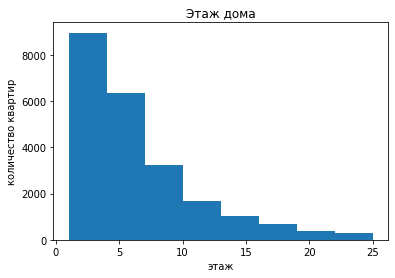


Максимальное расположение квартир на этаже:
7711     27
113      27
6157     27
23292    27
2629     27
13276    27
16644    27
4091     27
9799     26
4590     26
Name: floor, dtype: int64


In [61]:
plt.hist(data['floor'], bins=8, range=(1,25))
plt.title('Этаж дома')
plt.xlabel('этаж')
plt.ylabel('количество квартир')
plt.show()
print()
print('Максимальное расположение квартир на этаже:') 
print(data['floor'].sort_values(ascending=False).head(10))

Больше всего квартир располагаются на 1-4 этажах. Максимальный показатель имеет дом 18218

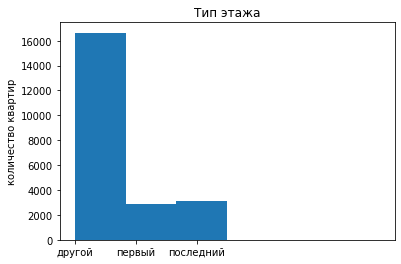

In [62]:
plt.hist(data['type_floors'], bins=6, range=(0,5))
plt.title('Тип этажа')
plt.ylabel('количество квартир')
plt.show()
print()

Больше всего квартир имеют другой тип этажа, при этом расположение квартир на последнем этаже больше, чем на первом.

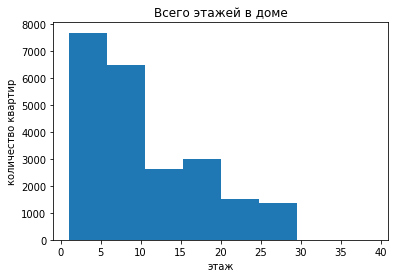


Максимальная этажность дома:
12950    28
14142    28
23017    28
18183    28
4558     28
14868    28
19139    28
16984    28
20876    28
14719    28
Name: floors_total, dtype: int64


In [63]:
plt.hist(data['floors_total'], bins=8, range=(1,39))
plt.title('Всего этажей в доме')
plt.xlabel('этаж')
plt.ylabel('количество квартир')
plt.show()
print()
print('Максимальная этажность дома:') 
print(data['floors_total'].sort_values(ascending=False).head(10)) 

Больше всего домов имеют от 2 до 5 этажей. Максимальную этажность имеет дом 2253.

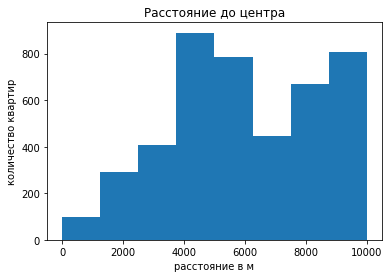


Максимальное расстояние до центра:
9640     65968.0
5340     65952.0
577      65764.0
20746    65105.0
5218     64857.0
18884    62706.0
2974     62454.0
16569    61495.0
23123    60223.0
4441     59626.0
Name: cityCenters_nearest, dtype: float64


In [64]:
plt.hist(data['cityCenters_nearest'], bins=8, range=(1,10000))
plt.title('Расстояние до центра')
plt.xlabel('расстояние в м')
plt.ylabel('количество квартир')
plt.show()
print()
print('Максимальное расстояние до центра:') 
print(data['cityCenters_nearest'].sort_values(ascending=False).head(10)) 

Максимальное количество домов имеют расстояние до центра города около 5 км. Максимальную отдаленность от центра имеет дом 9640

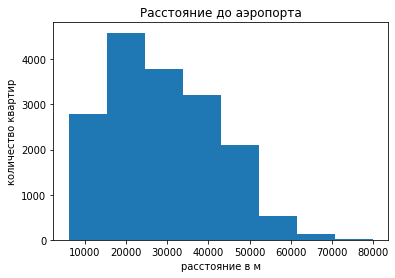


Максимальное расстояние до аэропорта:
9640     84869.0
5340     84853.0
577      84665.0
20746    84006.0
5218     83758.0
18884    81607.0
2974     81355.0
4441     78527.0
939      75646.0
376      73827.0
Name: airports_nearest, dtype: float64


In [65]:
plt.hist(data['airports_nearest'], bins=8, range=(6000,80000))
plt.title('Расстояние до аэропорта')
plt.xlabel('расстояние в м')
plt.ylabel('количество квартир')
plt.show()
print()
print('Максимальное расстояние до аэропорта:') 
print(data['airports_nearest'].sort_values(ascending=False).head(10)) 

Максимальное количество домов имеют расстояние до аэропорта около 15-20 км. Максимальную отдаленность от аэропорта имеет дом 9640

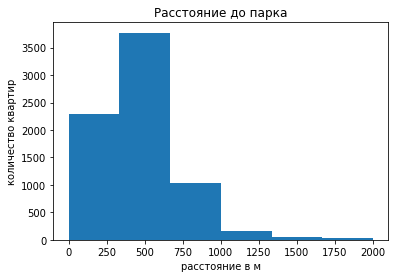


Максимальная расстояние до парка:
19430    3190.0
10959    3190.0
1590     3064.0
19208    3013.0
23080    2984.0
2659     2905.0
1860     2888.0
7855     2880.0
3865     2847.0
22003    2768.0
Name: parks_nearest, dtype: float64


In [66]:
plt.hist(data['parks_nearest'], bins=6, range=(1,2000))
plt.title('Расстояние до парка')
plt.xlabel('расстояние в м')
plt.ylabel('количество квартир')
plt.show()
print()
print('Максимальная расстояние до парка:') 
print(data['parks_nearest'].sort_values(ascending=False).head(10)) 


Максимальное количество домов имеют расстояние до парка около 500 м. Максимальную отдаленность от парка имеют дома 10959 и 19430. 

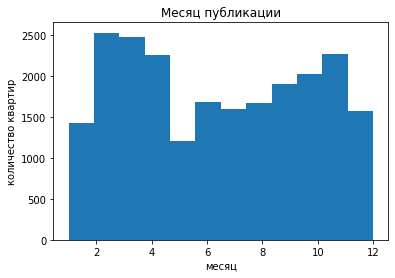

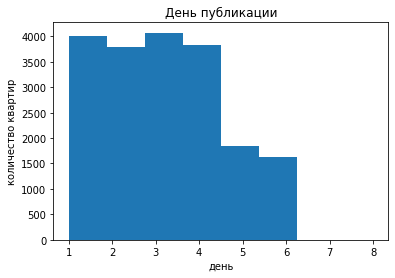

In [67]:
plt.hist(data['month'], bins=12, range=(1,12))
plt.title('Месяц публикации')
plt.xlabel('месяц')
plt.ylabel('количество квартир')
plt.show()
print()
plt.hist(data['weekday'], bins=8, range=(1,8))
plt.title('День публикации')
plt.xlabel('день')
plt.ylabel('количество квартир')
plt.show()
print()

Больше всего публикаций выкладываются в третьих числах второго месяца.

#### Изучение параметра скорости продажи квартиры по столбцу days_exposition

Изучим, как быстро продавались квартиры по столбцу days_exposition:

Медианное значение времени продажи квартиры:
93.0
Среднее значение времени продажи квартиры:
176.96383216499035


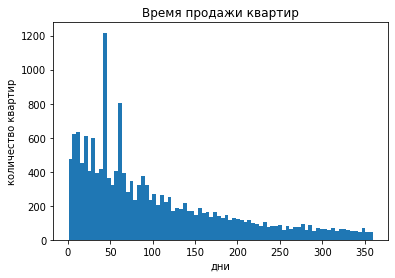

count    19686.000000
mean       176.963832
std        215.618791
min          1.000000
25%         44.000000
50%         93.000000
75%        225.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [68]:
print('Медианное значение времени продажи квартиры:') 
print(data['days_exposition'].median()) # Определяем мединное значение времени продажи

print('Среднее значение времени продажи квартиры:')
print(data['days_exposition'].mean()) # Определяем среднее значение времени продажи

plt.hist(data['days_exposition'], bins=80, range=(1,360)) 
plt.title('Время продажи квартир')
plt.xlabel('дни')
plt.ylabel('количество квартир')
plt.show()
print()

data['days_exposition'].describe() # выведем значения с помщью метода describe

Таким образом медианное значение продажи квартир составляет 93 дней.
Среднее значение равняется примерно 176 дня.
В целом, основная часть квартир продается в течении 93 дней. Также большая часть квартир продается в течении 44 дней, что можно охарактеризовать, как быструю продажу, при этом есть варинты продажи за 225 день, что можно обозначить, как долгая продажа. 

Теперь определим факторы, влияющие на стоимость объекта.

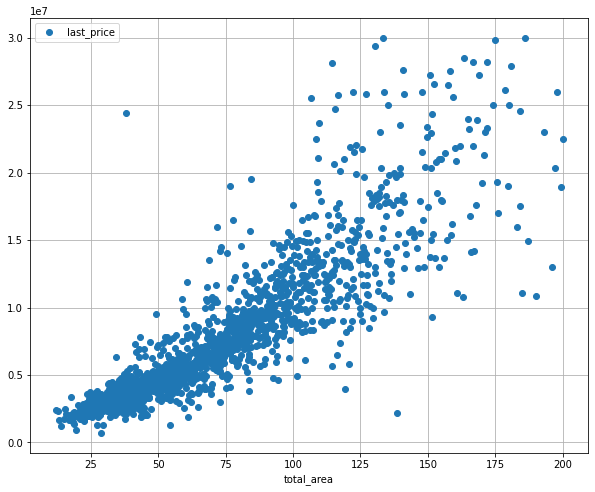

Корреляция цены и площади:
            total_area  last_price
total_area    1.000000    0.764561
last_price    0.764561    1.000000


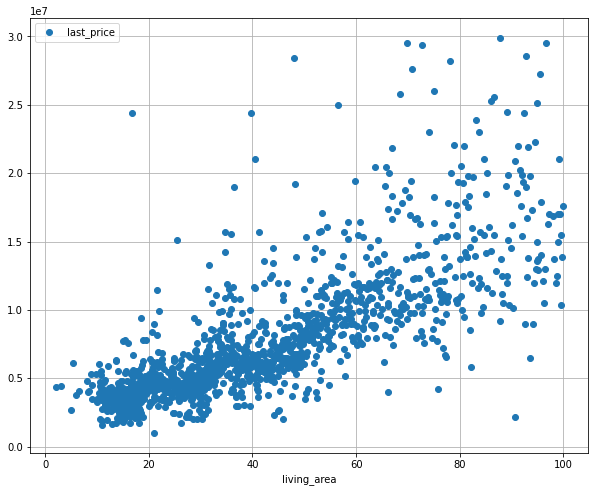

Корреляция цены от жилой площади:
             living_area  last_price
living_area     1.000000    0.607517
last_price      0.607517    1.000000


In [69]:
# Определяем зависимость цены от площади
(
    data.pivot_table(index='total_area', values='last_price') # Строим график и задаем ему размер
    .plot(grid=True, style='o', figsize=(10,8))
)
plt.show()
# Определяем корреляцию цены от площади
columns = data[['total_area', 'last_price']]
print('Корреляция цены и площади:')
print(columns.corr())


# Определяем зависимость цены от жилой площади
(
    data.pivot_table(index='living_area', values='last_price') # Строим график и задаем ему размер
    .plot(grid=True, style='o', figsize=(10,8))
)
plt.show()
# Определяем корреляцию цены от жилой площади
columns = data[['living_area', 'last_price']]
print('Корреляция цены от жилой площади:')
print(columns.corr())

In [70]:
# check
data.pivot_table(index='floor', values=['living_area', 'last_price']).head()

,last_price,living_area
floor,,
1,4.415662e+06,32.218867
2,5.327248e+06,33.362501
3,5.550417e+06,33.592476
4,5.536188e+06,33.566692
5,5.176072e+06,32.618660


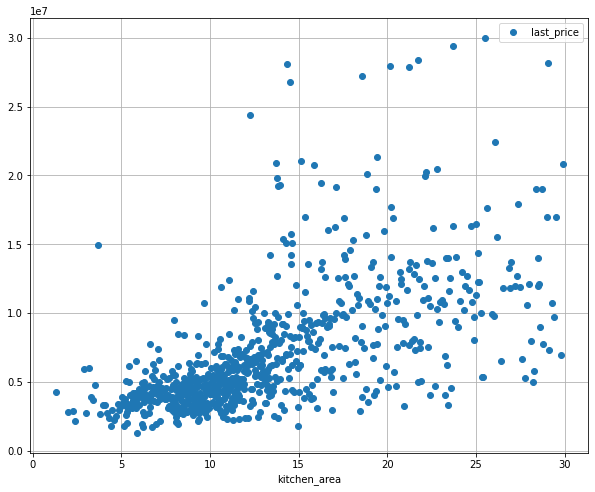

Корреляция цены от площади кухни
              kitchen_area  last_price
kitchen_area      1.000000    0.519701
last_price        0.519701    1.000000


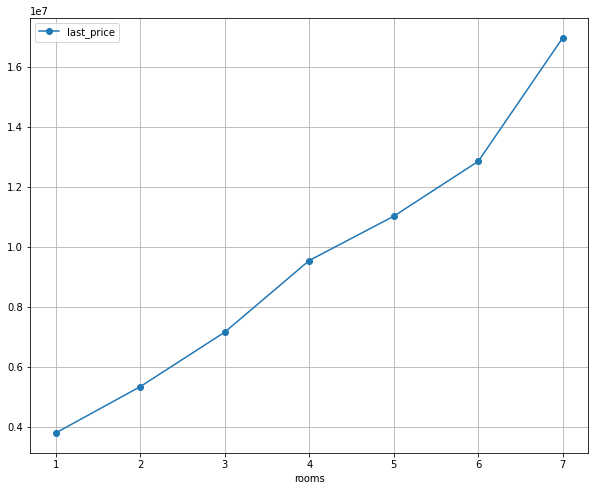

Корреляция цены от количества комнат
               rooms  last_price
rooms       1.000000    0.470028
last_price  0.470028    1.000000


In [71]:
# Определяем зависимость цены от площади кухни
(
    data.pivot_table(index='kitchen_area', values='last_price')
    .plot(grid=True, style='o', figsize=(10, 8))
)
plt.show()
# Определяем корреляцию цены от площади кухни
columns = data[['kitchen_area', 'last_price']]
print('Корреляция цены от площади кухни')
print(columns.corr())


# Определяем зависимость цены от количества комнат
(
    data.query('rooms > 0').pivot_table(index='rooms', values='last_price')
    .plot(grid=True, style='o-', figsize=(10,8))
)
plt.show()
# Определяем корреляцию цены от количества комнат
columns = data[['rooms', 'last_price']]
print('Корреляция цены от количества комнат')
print(columns.corr())


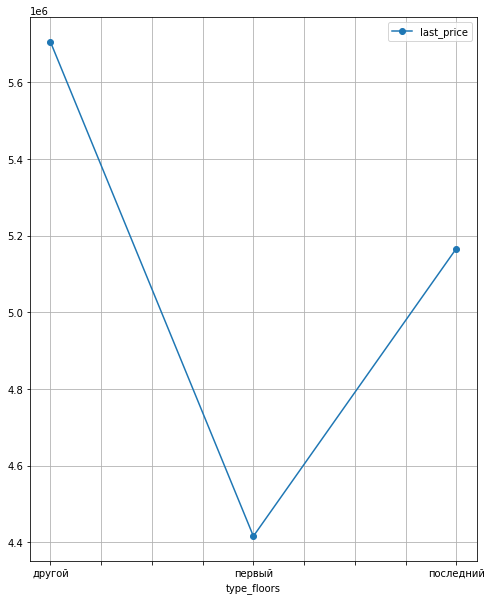

In [72]:
# Определяем зависимость цены от этажа, на котором расположена квартира
(
    data.pivot_table(index='type_floors', values='last_price')
    .plot(grid=True, style='o-', figsize=(8,10))
)
plt.show()

**Вывод**: Самая высокая зависимость наблюдается между ценой и площадью. Также высокая зависимость наблюдается между жилой площадью. Хорошая зависимость наблюдается между ценной и количеством комнат. Что касается расположения квартиры на этаже, то дороже всего в этом случае будут квартиры, расположенные на последних этажах.

#### Факторы влияющие на общую (полную) стоимость объекта

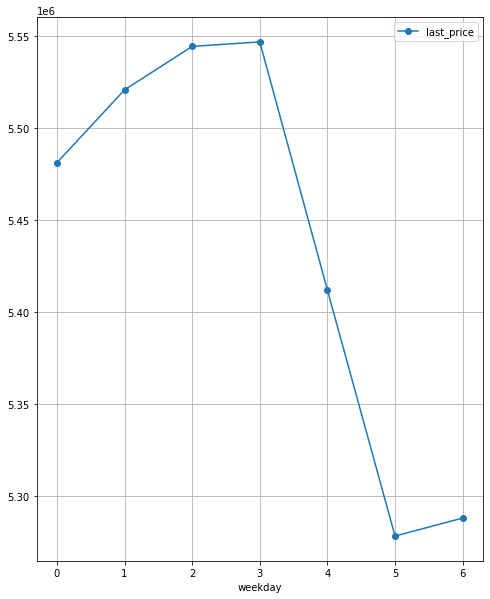

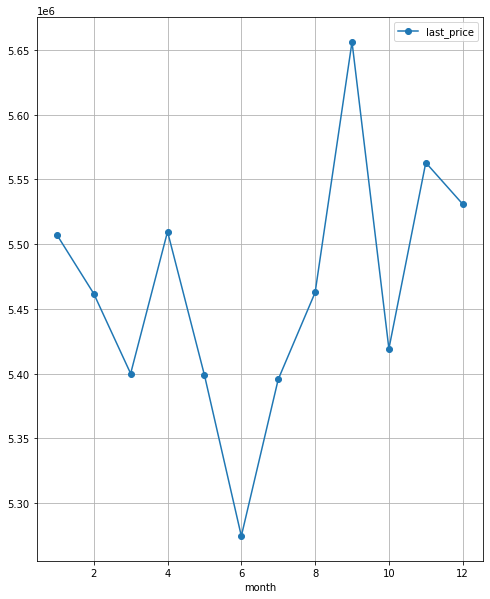

In [73]:
# Определяем зависимость цены от дня размещения:
(
    data.pivot_table(index='weekday', values='last_price')
    .plot(grid=True, style='o-', figsize=(8,10))
)
plt.show()
# Определяем зависимость цены от месяца размещения:
(
    data.pivot_table(index='month', values='last_price')
    .plot(grid=True, style='o-', figsize=(8,10))
)
plt.show()

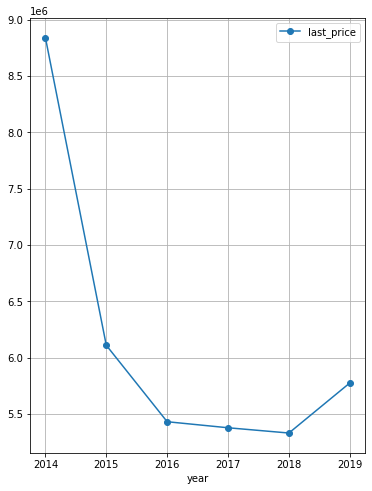

In [74]:
# Определяем зависимость цены от года размещения:
(
    data.pivot_table(index='year', values='last_price')
    .plot(grid=True, style='o-', figsize=(6,8))
)
plt.show()

**Вывод**: По дням самые высокие цены наблюдались в среду, дешевле всего в субботу. По месяцам более высокие цены на квартиры наблюдаются в декабре, а более низкие в октябре. В 2018 наблюдались самые низкие цены на квартиры, а самые высокие в 2014 году.

#### Определение средней цены одного квадратного метра в 10 населённых пунктах

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [75]:
# Сравниваем среднюю стоимость квадратного метра по наибольшему числу объявлений
# выведем 10 пунктов с наибольшим количеством объявлений и сохраним в таблицу в top_abs_cities 
top_abs_cities = data['locality_name'].value_counts().head(10) 
top_abs = data.query('locality_name in (@top_abs_cities.index)').pivot_table(values='price_sq_meters', index='locality_name')
# переведём цену в целочисленное значение 
top_abs = top_abs.astype(int) 
top_abs.sort_values('price_sq_meters', ascending=False)


,price_sq_meters
locality_name,
Санкт-Петербург,109944
Пушкин,102489
посёлок Кудрово,92541
посёлок Парголово,90317
посёлок Мурино,85628
посёлок Шушары,78627
Колпино,75332
Гатчина,68781
Всеволожск,68504


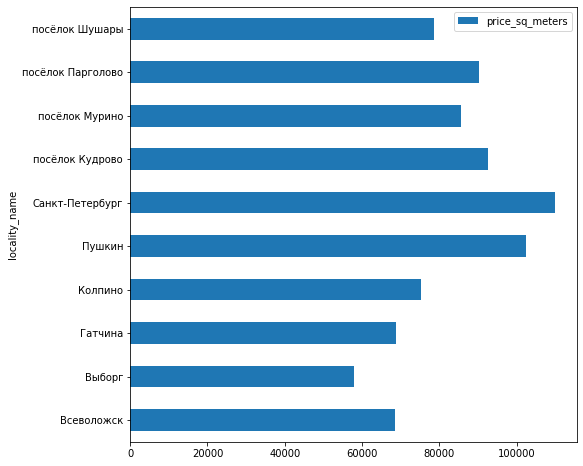

In [76]:
top_abs.plot(y='price_sq_meters', kind='barh', figsize=(8,8));

**Вывод**: Наибольшая средняя стоимость одного квадратного метра зафиксировано в Санкт-Петербурге. После него идет Пушкин, Наименьшую стоимость стоимость за один квадратный метр имеет город Выборг.

#### Вычисление средней цены каждого километра в Санкт-Петербурге

Вычислим среднюю цену каждого километра:

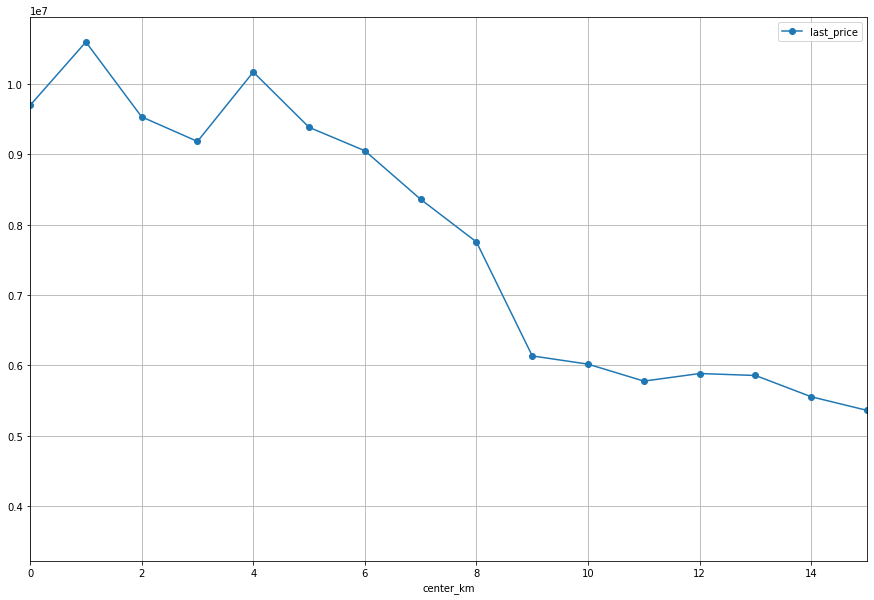

In [75]:
# Добавляем столбец с расстоянием до центра в км
data['center_km'] = data['cityCenters_nearest'] / 1000
# Округляем полученные значения до целого
data['center_km'] = data['center_km'].fillna(value=0).astype(int)
# Выбираем Санкт-Петербург, смотрим на график, где указана средняя стоимость для каждого км
(
    data.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='center_km', values='last_price')
    .plot(grid=True, style='o-', xlim=(0,15), figsize=(15, 10))
)
plt.show()

**Вывод**: Цена на стоимости жилья, после 7 км начинает резко снижаться, что может говорить о том, что центральной зоной является промежуток до 7 км.

### Общий вывод

В ходе проведенного исследовательского анализа получились следующие результаты. Так большая часть, продаваемых квартир:
* имеют площадь от 30 до 45 кв. м.
* имеют жилую площадь около 30 кв. м.
* имеют средний размер кухни 11 кв. м
* имеют цену около 3 млн рублей.
* имеют 1-2 комнаты
* имеют Высоту потолков от 2,5 до 2,75 м
* находятся на 1-4 этажах
* имеют не первый и не последний тип этажа
* имеют максимальную этажность от 2 до 5.
* имеют среднее расстояние до центра города около 5 км, до аэропорта 15-20 км, до парка 500 м.
* публикуются в первых числах четвертого месяца

Что касается продажи квартиры, то:
* Чаще всего её продают за 95 дней. Быстрым показателем по продажам является значение меньше 45 дней, большим показателем продажи является срок в 231 день. 

Основными факторами, влияющие на стоимость квартиры является:
* её площадь, а меньше всего на этот фактор влияет размер кухни.
Первый этаж в ценовом диапазоне дешевле остальных вариантов. При этом стоимость квартиры на последнем этаже ниже, чем на других этажах, кроме первого.

Стоимость квадратного метра для:
* Санкт-Петербурга -114842 руб
* Пушкина - 103125 руб
* посёлка Кудрово	- 92473 руб
* посёлка Парголово - 90175 руб
* посёлка Мурино - 85629 руб
* посёлка Шушары - 78550 руб
* Колпина - 75424 руб
* Гатчины - 68745 руб
* Всеволожска - 68718 руб
* Выборга - 58237 руб

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [X]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [X]  определены пропущенные значения
- [X]  заполнены пропущенные значения там, где это возможно
- [X]  есть пояснение, какие пропущенные значения обнаружены
- [X]  изменены типы данных
- [X]  есть пояснение, в каких столбцах изменены типы и почему
- [X]  устранены неявные дубликаты в названиях населённых пунктов
- [X]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [X]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [X]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [X]  посчитано и добавлено в таблицу: месяц публикации объявления
- [X]  посчитано и добавлено в таблицу: год публикации объявления
- [X]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [X]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [X]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [X]  построены гистограммы для каждого параметра
- [X]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [X]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [X]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [X]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [X]  в каждом этапе есть промежуточные выводы
- [X]  есть общий вывод